C:\Users\SKB PC\AppData\Local\Temp\ipykernel_8912\1323404964.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


Linear Regression MSE (Before Tuning): 0.3037
Random Forest MSE (Before Tuning): 0.3252
Gradient Boosting MSE (Before Tuning): 0.3171
SVR MSE (Before Tuning): 0.3546
XGBoost MSE (Before Tuning): 0.4054
Linear Regression MSE (After Tuning): 0.3037
Random Forest MSE (After Tuning): 0.3111
Gradient Boosting MSE (After Tuning): 0.2999
SVR MSE (After Tuning): 0.3090
XGBoost MSE (After Tuning): 0.3006
The best model selected is Gradient Boosting with MSE: 0.2999


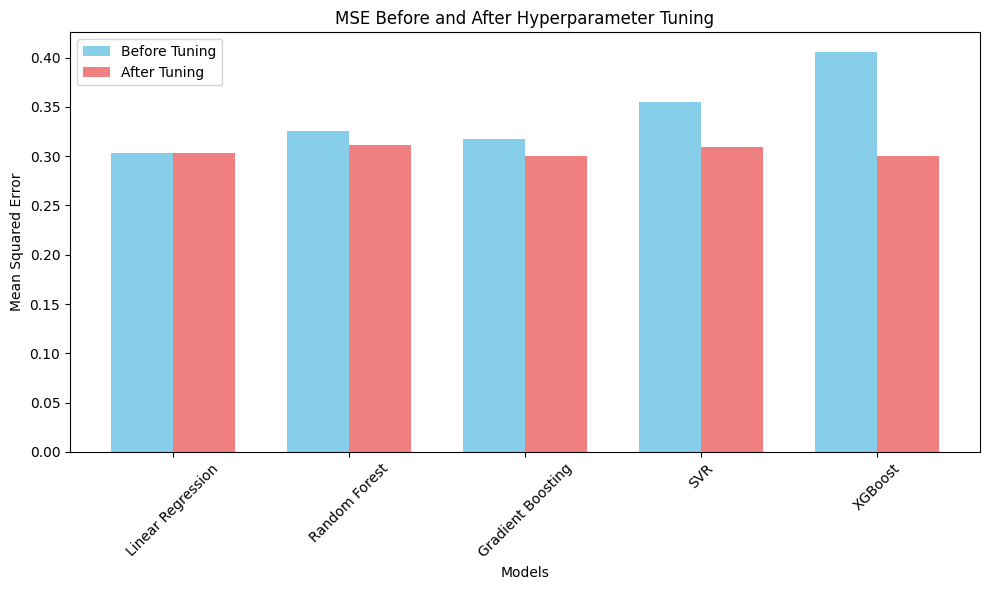

MSE comparison table saved as 'mse_comparison.csv'
MSE comparison table saved as 'mse_table.png'


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('petrol.csv')  # Adjust path if needed

# Preprocessing
# Encode categorical variables: Traffic Conditions and Road Type
data = pd.get_dummies(data, columns=['Traffic Conditions', 'Road Type'], drop_first=True)

# Define features and target
features = ['Engine Size', 'Age of Vehicle', 'Temperature', 'Wind Speed', 'Speed'] + \
           [col for col in data.columns if 'Traffic Conditions_' in col or 'Road Type_' in col]
X = data[features]
y = data['NOx Emissions']

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ['Engine Size', 'Age of Vehicle', 'Temperature', 'Wind Speed', 'Speed']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(random_state=42)
}

# Store MSE for before and after tuning
mse_before = {}
mse_after = {}

# Train and evaluate models before tuning
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_before[name] = mse
    print(f"{name} MSE (Before Tuning): {mse:.4f}")

# Hyperparameter tuning with GridSearchCV
param_grids = {
    'Linear Regression': {},  # No hyperparameters to tune
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'epsilon': [0.1, 0.2]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
}

for name, model in models.items():
    if param_grids[name]:  # Skip Linear Regression
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_after[name] = mse
    print(f"{name} MSE (After Tuning): {mse:.4f}")
# Select the best model based on lowest MSE after tuning
best_model_name = min(mse_after, key=mse_after.get)
best_mse = mse_after[best_model_name]
print(f"The best model selected is {best_model_name} with MSE: {best_mse:.4f}")

# Plot MSE before and after tuning
labels = list(models.keys())
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, list(mse_before.values()), width, label='Before Tuning', color='skyblue')
ax.bar(x + width/2, list(mse_after.values()), width, label='After Tuning', color='lightcoral')
ax.set_xlabel('Models')
ax.set_ylabel('Mean Squared Error')
ax.set_title('MSE Before and After Hyperparameter Tuning')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()




# Create a DataFrame to store MSE values
mse_table = pd.DataFrame({
    'Model': list(models.keys()),
    'MSE Before Tuning': list(mse_before.values()),
    'MSE After Tuning': list(mse_after.values())
})

# Save the DataFrame to a CSV file
mse_table.to_csv('mse_comparison.csv', index=False)
print("MSE comparison table saved as 'mse_comparison.csv'")

# Generate a PNG image of the table
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=mse_table.values, colLabels=mse_table.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Adjust table size
plt.savefig('mse_table.png', bbox_inches='tight', dpi=300)
plt.close()
print("MSE comparison table saved as 'mse_table.png'")

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import joblib

# Assume data is preprocessed (from previous code)
# Load and preprocess data (repeating key steps for context)
data = pd.read_csv('petrol.csv')
data = pd.get_dummies(data, columns=['Traffic Conditions', 'Road Type'], drop_first=True)
features = ['Engine Size', 'Age of Vehicle', 'Temperature', 'Wind Speed', 'Speed'] + \
           [col for col in data.columns if 'Traffic Conditions_' in col or 'Road Type_' in col]
X = data[features]
y = data['NOx Emissions']

# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ['Engine Size', 'Age of Vehicle', 'Temperature', 'Wind Speed', 'Speed']
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Train-test split (for model training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tuned Gradient Boosting model (using best parameters from previous tuning)
# Example: Assume GridSearchCV found these parameters (adjust based on your tuning results)
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train the model
gb_model.fit(X_train, y_train)

# Predict NOx Emissions
y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Tuned Gradient Boosting MSE: {mse:.4f}")

# Save the model and scaler to .pkl files
joblib.dump(gb_model, 'gradient_boosting_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model and scaler saved as 'gradient_boosting_model.pkl' and 'scaler.pkl'")



C:\Users\SKB PC\AppData\Local\Temp\ipykernel_14688\3512359347.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


Tuned Gradient Boosting MSE: 0.3319
Model and scaler saved as 'gradient_boosting_model.pkl' and 'scaler.pkl'


In [4]:

import pandas as pd
import numpy as np
df = pd.read_csv("petrol.csv")
print("Shape of the dataset:", df.shape)
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

# List of column names
print("Column names:")
print(df.columns.tolist())

Shape of the dataset: (2468, 8)
Number of rows: 2468
Number of columns: 8
Column names:
['Engine Size', 'Age of Vehicle', 'Speed', 'Road Type', 'Traffic Conditions', 'Temperature', 'Wind Speed', 'NOx Emissions']


In [6]:
print(X_train.columns.tolist())

['Engine Size', 'Age of Vehicle', 'Temperature', 'Wind Speed', 'Speed', 'Traffic Conditions_Heavy', 'Traffic Conditions_Moderate', 'Road Type_Highway', 'Road Type_Rural']


In [7]:
# In training script
print(pd.Series(model.feature_importances_, index=features).sort_values(ascending=False))

Road Type_Highway              0.130352
Speed                          0.125273
Wind Speed                     0.122056
Temperature                    0.119370
Traffic Conditions_Moderate    0.117582
Age of Vehicle                 0.105679
Road Type_Rural                0.094312
Traffic Conditions_Heavy       0.093468
Engine Size                    0.091908
dtype: float32


In [8]:
import pandas as pd

# Load your dataset (replace 'your_file.csv' with your actual file or use an existing DataFrame)
df = pd.read_csv('petrol.csv')  # or use df = your_dataframe if already loaded

# Display maximum value of each column
max_values = df.max()

# Print the result
print("Maximum value in each column:")
print(max_values)


Maximum value in each column:
Engine Size             5.996622
Age of Vehicle                29
Speed                 119.951806
Road Type                  Rural
Traffic Conditions      Moderate
Temperature            39.991188
Wind Speed             19.997502
NOx Emissions           1.999739
dtype: object
